When a medical claim is submitted, the insurance provider must process the claim to determine the correct financial responsibility of the insurance provider and the patient. The process to determine this is broadly known as claims adjudication. It involves creating a claims processing workflow that checks each claim for authenticity, correctness, and validity based on coverage. Some of the steps in this workflow involve working with unstructured data (data that is not represented as rows and columns) which requires manual steps in the workflow to extract the information buried in the unstructured notes. According to the 2018 CAHQ index report, there were approximately 6.1 billion medical claims submitted in 2018, which represents a 4 percent increase in the volume from 2017, and it’s expected to continue rising in subsequent years. To process such volumes in a cost effective and scalable manner, healthcare payers are increasingly looking at machine learning to reduce dependency on humans and rely on automation as much as possible. Additionally, analyzing and interpreting health claim data is powerful in driving improvements in population health to address issues related to cost, quality and outcomes. According to the CDC report analyzing claim documents will help identify certain behaviors that would help in preventing or delaying the development of a medical condition. Healthcare is a data intense industry, and customers are looking for ways to automate and analyze these data.

In [2]:
import boto3
import json
import boto3
import re
import csv
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
from pprint import pprint

from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

In [3]:
!pip install amazon-textract-response-parser

In [4]:
role = get_execution_role()
#print("RoleArn: {}".format(role))

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'claims-process-textract'

# Sample Document

30 fields. 2 fileds are optional [ local use, xxx]
member id field is a mandatory field

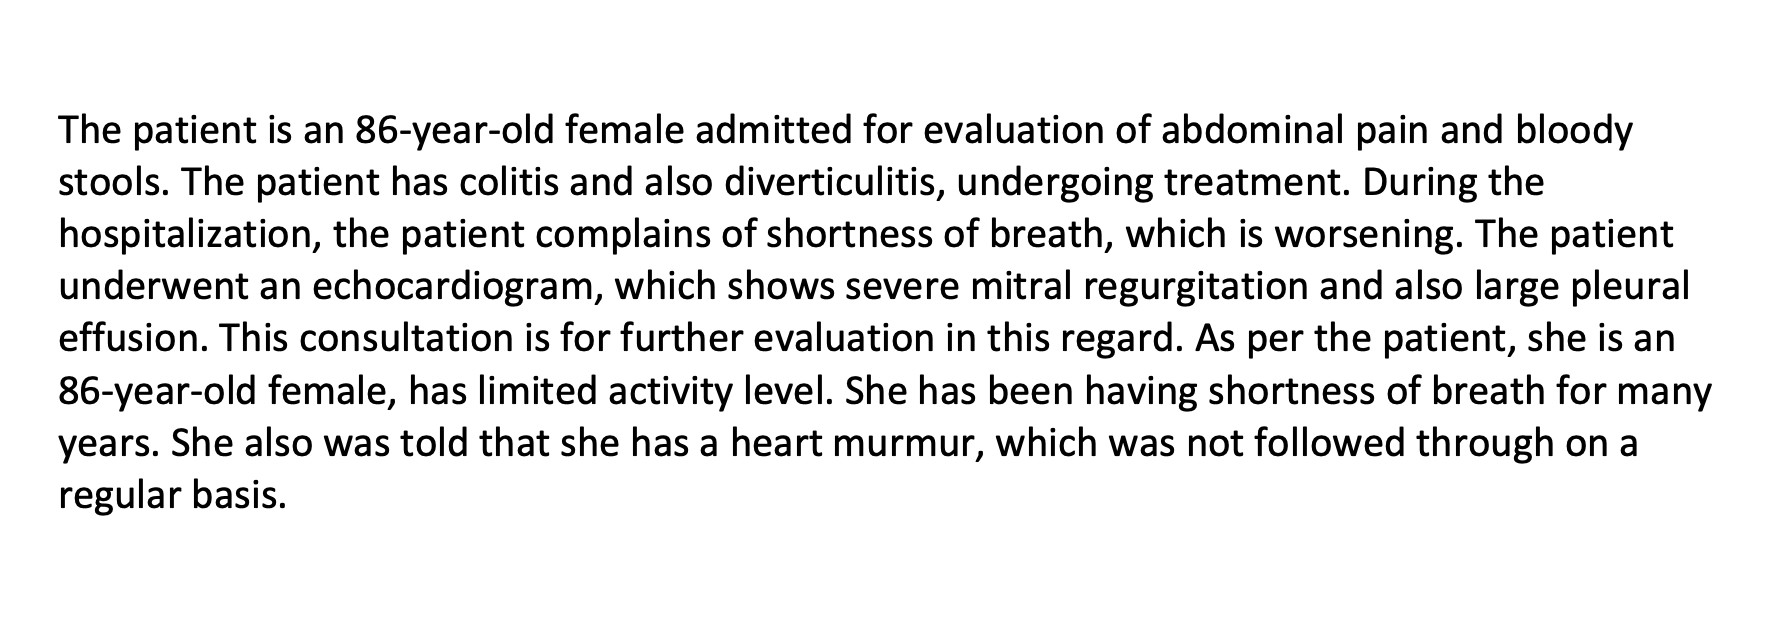

In [5]:
# Document

documentName = "doctornotes1.png"

display(Image(filename=documentName))

# Data Extraction

In [6]:
# process using image bytes
def calltextract(documentName): 
    client = boto3.client(service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com')

    with open(documentName, 'rb') as file:
            img_test = file.read()
            bytes_test = bytearray(img_test)
            print('Image loaded', documentName)

    # process using image bytes
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['FORMS'])

    return response

In [7]:
response= calltextract(documentName)
print(response)

Image loaded doctornotes1.png
{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 1.0, 'Height': 1.0, 'Left': 0.0, 'Top': 0.0}, 'Polygon': [{'X': 4.247091688087781e-17, 'Y': 0.0}, {'X': 1.0, 'Y': 3.531263151746437e-16}, {'X': 1.0, 'Y': 1.0}, {'X': 0.0, 'Y': 1.0}]}, 'Id': '56faaf57-4f3e-45df-bcad-3cda4f1746c9', 'Relationships': [{'Type': 'CHILD', 'Ids': ['464cd122-5dc8-4e7b-81c5-7a13212a014f', 'f741f103-31a1-4c98-a79e-fb17cc3e371e', '5f373999-06ff-4135-9f69-c2c05a7fd7ae', '10999858-8702-4af7-8550-8b4e8b7c6f85', '3430de6b-bc0a-4437-bc69-723866b9e29d', '3ed8054a-c228-457a-80d9-879c1778c953', 'c88d531f-c144-4dc9-a15c-904b13013fc2', 'cfe4a8c9-a375-460a-a24e-4a5d54da6137', 'ae9caaee-9cc9-4a02-9f03-26edc8516396', '46d86ab5-7a84-4ad4-abc0-8e7f89b08cf2', 'ee42b987-2ca3-4379-ab7a-02eb923fb2c1', 'c95ce457-8fb8-4c8f-ae0c-e43f36de5dda', 'b715d9a2-54c9-4afd-9bff-2cf7241d22e3', '8f24e10a-081d-41aa-94f1-3cc89e48e1f7', '766d12db-93f3-40a4-b3eb-5eda4

In [11]:
# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text = text + " " + item["Text"]
        
        
print(text)

 The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion. This consultation is for further evaluation in this regard. As per the patient, she is an 86-year-old female, has limited activity level. She has been having shortness of breath for many years. She also was told that she has a heart murmur, which was not followed through on a regular basis.


In [22]:
# Call Comprehend Medical
comprehendmedical = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehendmedical.detect_entities_v2(Text=text)

print("\nMedical Condition\n========")
for entity in cm_json_data["Entities"]:

    if entity["Category"] == "MEDICAL_CONDITION":
        print(entity["Text"])

print("\nAnatomy\n========")
for entity in cm_json_data["Entities"]:     

    if entity["Category"] == "ANATOMY":
        print(entity["Text"])
        
print("\nTest Treatment Procedure\n========")
for entity in cm_json_data["Entities"]:     

    if entity["Category"] == "TEST_TREATMENT_PROCEDURE":
        print(entity["Text"])
        

    



Medical Condition
abdominal pain
bloody stools
colitis
diverticulitis
shortness of breath
mitral regurgitation
pleural effusion
limited activity level
shortness of breath
murmur

Anatomy
abdominal
mitral
pleural
heart

Test Treatment Procedure
treatment
echocardiogram


### Medication and Doasage with RxNorm

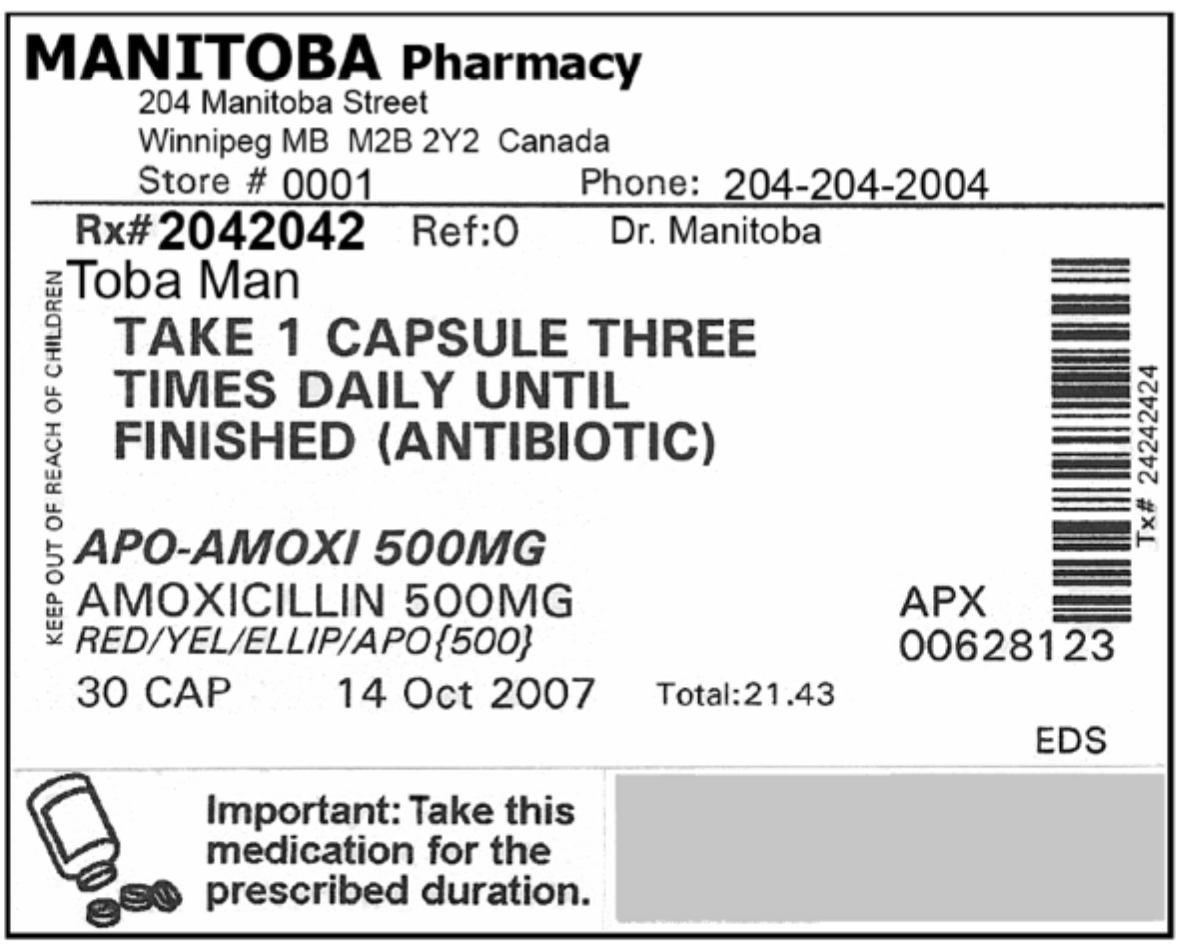

In [27]:
documentName = "prescription.png"
display(Image(filename=documentName))

In [28]:

response= calltextract(documentName)
#print(response)

# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text = text + " " + item["Text"]
        
        
print(text)

Image loaded prescription.png
 MANITOBA Pharmacy 204 Manitoba Street Winnipeg MB M2B 2Y2 Canada Store # 0001 Phone: 204-204-2004 Rx#2042042 Ref:0 Dr. Manitoba Toba Man TAKE 1 CAPSULE THREE TIMES DAILY UNTIL FINISHED (ANTIBIOTIC) APO-AMOXI 500MG AMOXICILLIN 500MG APX RED/YEL/ELLIP/APO{500) 00628123 30 CAP 14 Oct 2007 Total:21.43 EDS D Important: Take this medication for the prescribed duration.


In [38]:
# Call Comprehend Medical
comprehendmedical = boto3.client(service_name='comprehendmedical')
# Detect medical entities


cm_json_data =  comprehendmedical.detect_entities_v2(Text=text)
print("MEDICATION LIST\n")
for entity in cm_json_data["Entities"]:

    if entity["Category"] == "MEDICATION":
        print(entity["Text"])
        for key in entity:
            Attribute_List = []
            if key == 'Attributes':
                for r in entity[key]:
                        Attribute_List.append(r['Type']+':'+r['Text'])
        print(str(Attribute_List))
        

MEDICATION LIST

APO-AMOXI
['DOSAGE:500MG', 'DOSAGE:500MG', 'FORM:CAP']
AMOXICILLIN
['DOSAGE:500MG', 'FORM:CAP']


In [41]:

cm_json_data =  comprehendmedical.infer_rx_norm(Text=text)

print("\n RxNorm Code\n========")

for entity in cm_json_data["Entities"]:
    
    for rx in entity["RxNormConcepts"]:
        print(rx['Code'])
            



 RxNorm Code
1314210
900048
852494
900052
1314330
308191
308212
308192
723
1721474


## ICD 10 CM Code

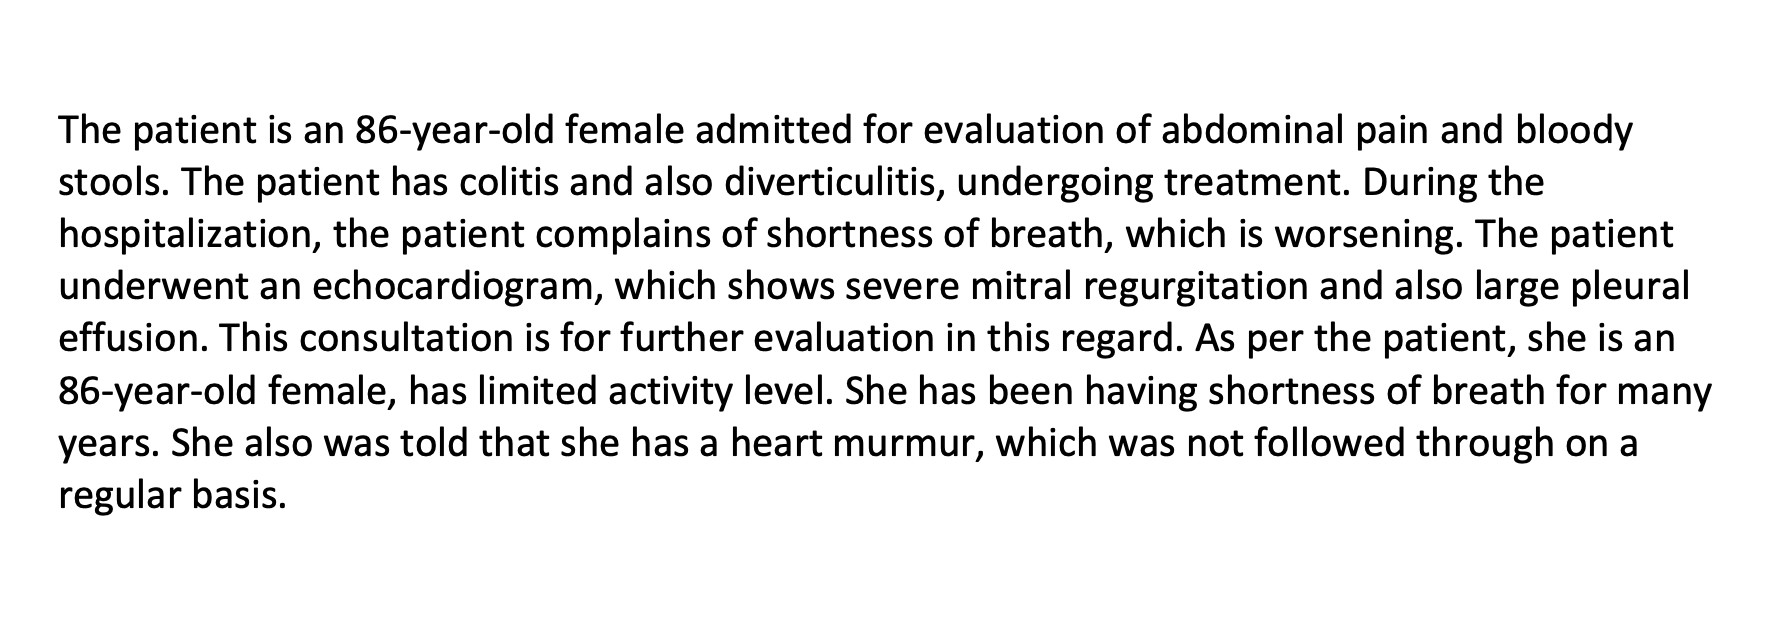

Image loaded doctornotes1.png
 The patient is an 86-year-old female admitted for evaluation of abdominal pain and bloody stools. The patient has colitis and also diverticulitis, undergoing treatment. During the hospitalization, the patient complains of shortness of breath, which is worsening. The patient underwent an echocardiogram, which shows severe mitral regurgitation and also large pleural effusion. This consultation is for further evaluation in this regard. As per the patient, she is an 86-year-old female, has limited activity level. She has been having shortness of breath for many years. She also was told that she has a heart murmur, which was not followed through on a regular basis.


In [44]:
# Document

documentName = "doctornotes1.png"

display(Image(filename=documentName))
response= calltextract(documentName)
#print(response)

# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        text = text + " " + item["Text"]
        
        
print(text)

In [45]:
cm_json_data =  comprehendmedical.infer_icd10_cm(Text=text)

print("\n Medical coding\n========")

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        
        if (icd["Score"] >= 0.93):
            code = icd["Code"]
            print(code)
            



 Medical coding
K92.1


### End

In [117]:
#Extract key values
# Iterate over elements in the document
from trp import Document
def getformkeyvalue(response):
    doc = Document(response)
    
    key_map = {}
    for page in doc.pages:
        # Print fields
        for field in page.form.fields:
            if field is None or field.key is None or field.value is None:
                continue
        
            key_map[field.key.text] = field.value.text
    return key_map

In [118]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'YES': 'NOT_SELECTED', 'NO': 'NOT_SELECTED', 'ZIP CODE': '12345', 'Full-Time Student': 'NOT_SELECTED', 'CITY': 'Any City', "5. PATIENT'S ADDRESS (No., Street)": '1 Any street,', 'Part-Time Student': 'NOT_SELECTED', "c. EMPLOYER'S NAME OR SCHOOL NAME": 'Any employer', "2. PATIENT'S NAME (Last Name, First Name, Middle Initial)": 'Doe, Jane', 'Other': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE (Include Area Code)': '( )', 'M': 'NOT_SELECTED', 'TELEPHONE (INCLUDE AREA CODE)': '( )', 'Self': 'SELECTED', 'Child': 'NOT_SELECTED', 'd. INSURANCE PLAN NAME OR PROGRAM NAME': 'Any insurance', 'Spouse': 'NOT_SELECTED', "(Sponsor's SSN)": 'NOT_SELECTED', 'DATE': '1-1-2021', '(Medicaid #)': 'NOT_SELECTED', 'F': 'NOT_SELECTED', 'Married': 'SELECTED', '(Medicare #)': 'SELECTED', '(ID)': 'NOT_SELECTED', '3.': 'K92.1', 'SIGNED': 'Name', 'FECA BLK LUNG (SSN)': 'NOT_SELECTED', "1a. INSURED'S I.D. NUMBER": '1-1111-1111', '(VA File #)': 'NOT_SELECTED'}


# Post processing - Check for completeness - Acceptance Process
Check for validation using business rules for all the details in the claims document is present.
Checking if claim Id is 12 digit and zip code is digit

Adjudication - checking for code
participation, expectation rule - prior auth details is present
Evaluation - patient benefits and provider details for what is covered
Determination - payment, partial, denial

In [119]:
def validate(body):
    json_acceptable_string = body.replace("'", "\"")
    
    json_data = json.loads(body)
    
    zip = json_data['ZIP CODE']
    
    id = json_data['1a. INSURED\'S I.D. NUMBER']
    
    diagnosiscode = json_data["3."]
    print(diagnosiscode)
    print(id)
    print(zip)
    if(not zip.strip().isdigit()):
        return False, id, diagnosiscode, "Zip code invalid"
    length = len(id.strip())
    if(length != 11):
        return False, id, diagnosiscode, "Invalid claim Id"
    return True, id, diagnosiscode, "Ok"

In [120]:
 # Validate 
textract_json= json.dumps(get_form_keys,indent=2)
res, formid, diagnosiscode, result = validate(textract_json)
print(result)
print(formid)

K92.1
1-1111-1111
12345
Ok
1-1111-1111


# Enrich with medical insights
Valid Medical Intake Form send to Comprehend medical to gain insights

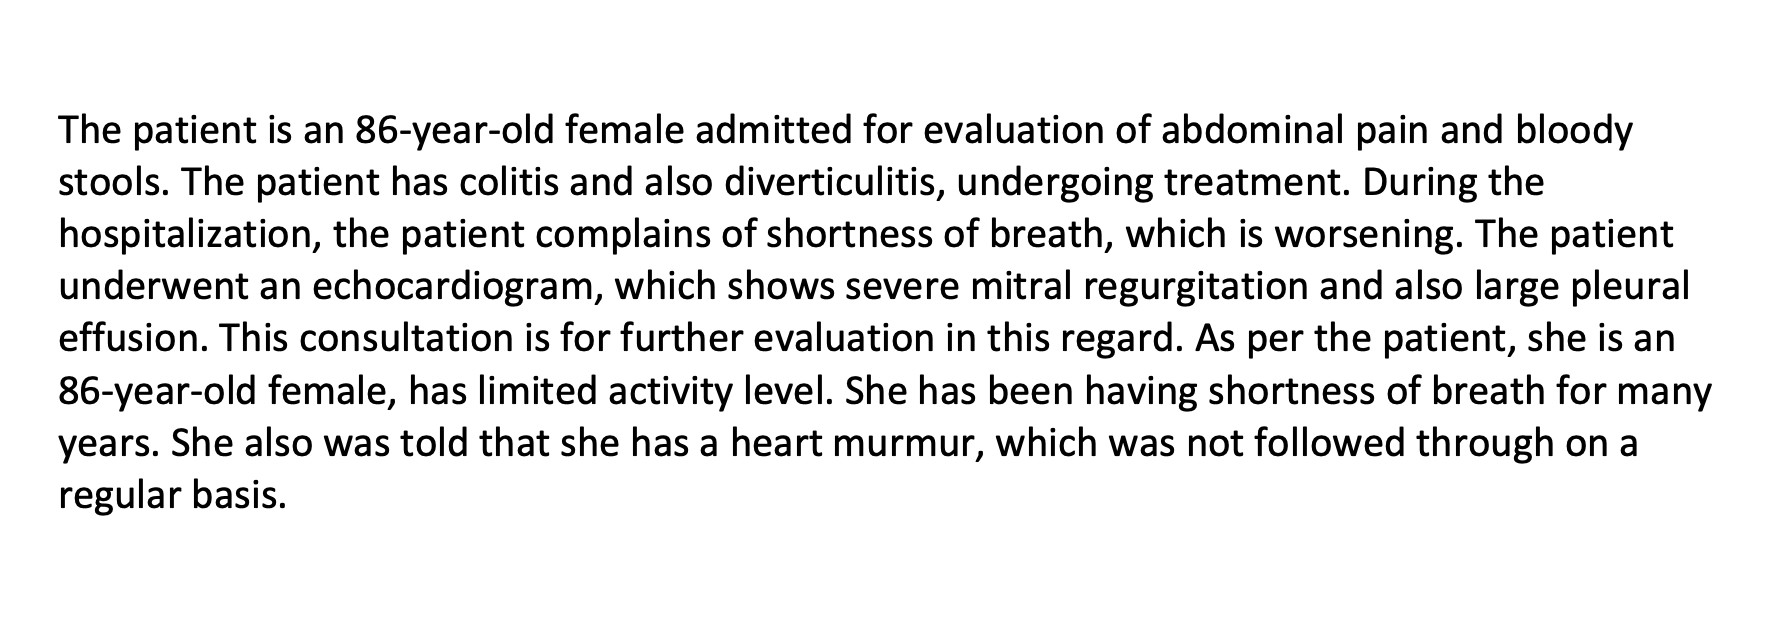

In [135]:
documentName = "doctornotes1.png"
display(Image(filename=documentName))



In [136]:
response= calltextract(documentName)
# Print text
print("\nText\n========")
text = ""
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]

Image loaded doctornotes1.png

Text
The patient is an 86-year-old female admitted for evaluation of abdominal pain and
bloody
stools. The patient has colitis and also diverticulitis, undergoing treatment. During the
hospitalization, the patient complains of shortness of breath, which is worsening. The patient
underwent an echocardiogram, which shows severe mitral regurgitation and
also
large
pleural
effusion. This consultation is for further evaluation in this regard. As per the patient, she
is
an
86-year-old female, has limited activity level. She has been having shortness of breath for
many
years. She also was told that she has a heart murmur, which was not followed through
on
a
regular basis.



## Get Medical Insights

In [122]:
comprehend = boto3.client(service_name='comprehendmedical')
# Detect medical entities

cm_json_data =  comprehend.detect_entities_v2(Text=text)

print("\nMedical Entities\n========")
for entity in cm_json_data["Entities"]:
    print("- {}".format(entity["Text"]))
    print ("   Type: {}".format(entity["Type"]))
    print ("   Category: {}".format(entity["Category"]))
    if(entity["Traits"]):
        print("   Traits:")
        for trait in entity["Traits"]:
            print ("    - {}".format(trait["Name"]))
    print("\n")


Medical Entities
- 86
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- abdominal pain
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- bloody stools
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- colitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- diverticulitis
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- shortness of breath
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- echocardiogram
   Type: TEST_NAME
   Category: TEST_TREATMENT_PROCEDURE


- mitral regurgitation
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- pleural effusion
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - DIAGNOSIS


- 86
   Type: AGE
   Category: PROTECTED_HEALTH_INFORMATION


- limited activity level
   Type: DX_NAME
   Category: MEDICAL_CONDITION
   Traits:
    - SYMPTOM


- shortness of breath
   

In [123]:
cm_json_data =  comprehend.infer_icd10_cm(Text=text)

print("\n Medical coding\n========")

for entity in cm_json_data["Entities"]:
    
    for icd in entity["ICD10CMConcepts"]:
        
        if (icd["Score"] >= 0.93):
            code = icd["Code"]
            print(code)
            



 Medical coding
K92.1


## Post Processing - Compare the dignosis code from the RAW doctor's notes

In [124]:
print("diagnosis code from claim form", diagnosiscode)
print("diagnosis code from raw doctor's note", code)

diagnosis code from claim form K92.1
diagnosis code from raw doctor's note K92.1


Writing entities to CSV File

# Invalid Claim

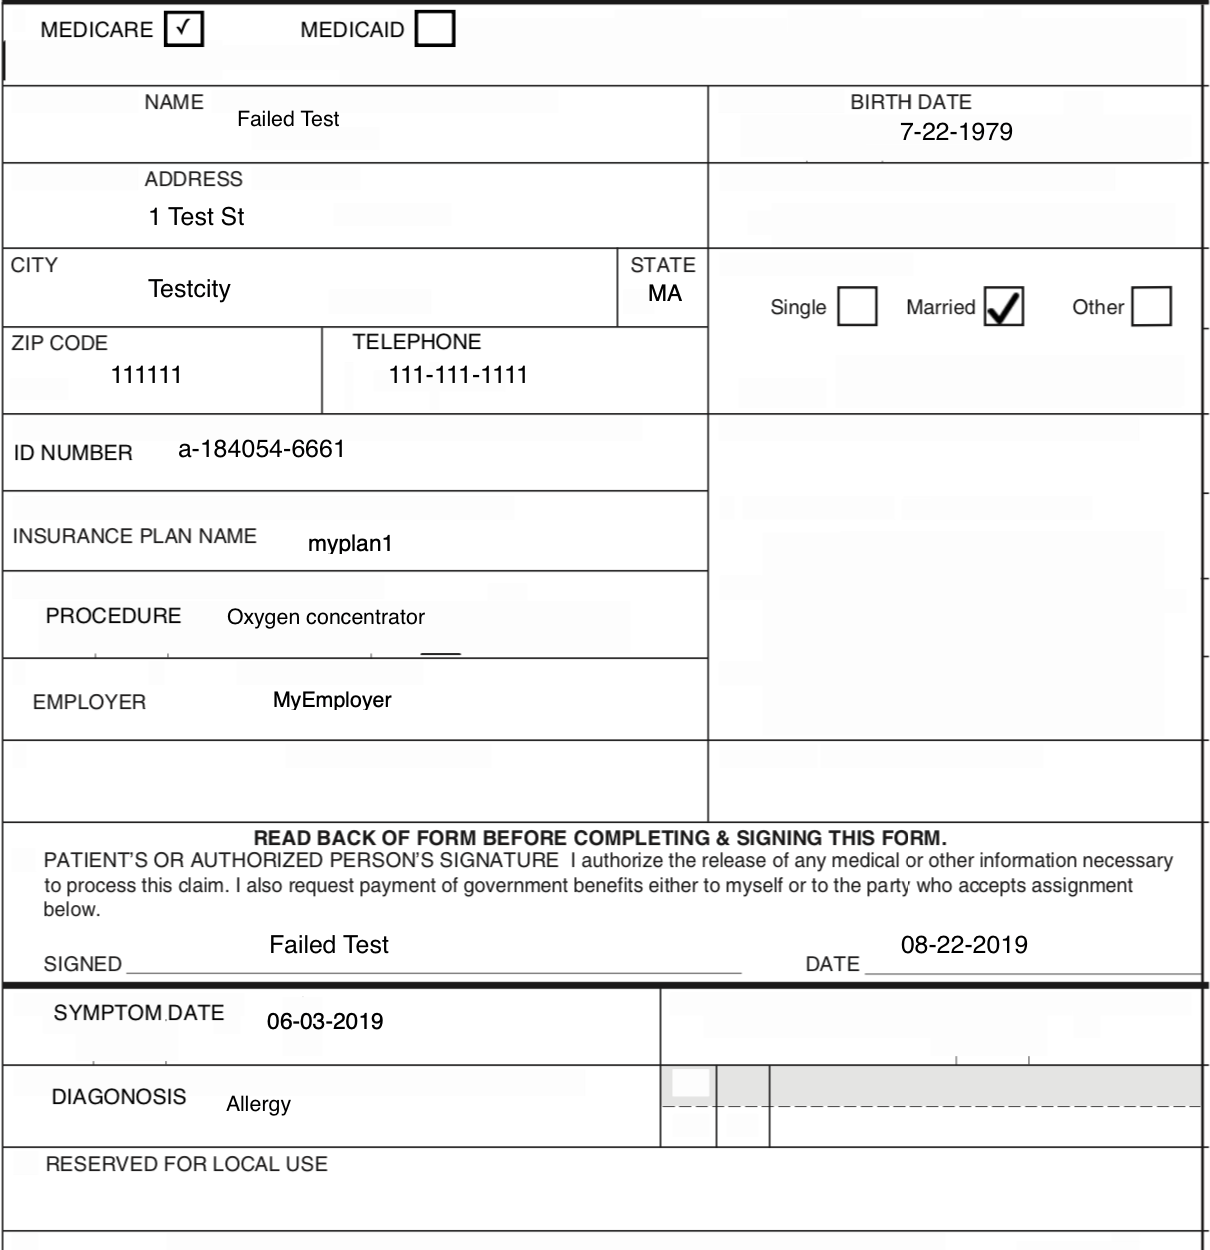

In [126]:
InvalidDocument = "failedtest.png"

display(Image(filename=InvalidDocument))

In [127]:
response = calltextract(InvalidDocument)

Image loaded failedtest.png


In [128]:
get_form_keys = getformkeyvalue(response)
print(get_form_keys)

{'Married': 'SELECTED', 'Other': 'NOT_SELECTED', 'MEDICAID': 'NOT_SELECTED', 'Single': 'NOT_SELECTED', 'TELEPHONE': '111-111-1111', 'ZIP CODE': '111111', 'STATE': 'MA', 'INSURANCE PLAN NAME': 'myplan1', 'ID NUMBER': 'a-184054-6661', 'ADDRESS': '1 Test St', 'NAME': 'Failed Test', 'DATE': '08-22-2019', 'SIGNED': 'Failed Test', 'MEDICARE': 'SELECTED', 'DIAGONOSIS': 'Allergy', 'BIRTH DATE': '7-22-1979', 'CITY': 'Testcity', 'SYMPTOMDATE': '06-03-2019', 'PROCEDURE': 'Oxygen concentrator', 'EMPLOYER': 'MyEmployer'}


In [133]:
 #In Validate 
textract_json= json.dumps(get_form_keys,indent=2)
json_data = json.loads(textract_json)

id = json_data['ID NUMBER']
print(id)

length = len(id.strip())
if(length != 11):
    print("Invalid claim Id")


a-184054-6661
Invalid claim Id


Delete the Amazon s3 bucket and the files in the buckethttps://docs.aws.amazon.com/AmazonS3/latest/userguide/delete-bucket.html